Spark script and the hive scripts were executed in Putty CLI with and SSH concetion to the Amazon EMR.

**Run the Results section for comparison of already obtained results**

# spark script

In [ ]:
import json
from pyspark.sql import SparkSession
import numpy as np
from collections import defaultdict
import time

S3_DATA_SOURCE_PATH = 's3://hivevsapachesqls3/data/DelayedFlights-updated.csv'
S3_DATA_OUTPUT_PATH = 's3://hivevsapachesqls3/output/Spark/'

def main():
    # Start the SparkSession
    spark = SparkSession.builder.appName('mapReduceVsSparkApp').getOrCreate()

    # Load the data from S3 bucket
    all_data = spark.read.csv(S3_DATA_SOURCE_PATH, header=True)
    all_data.createOrReplaceTempView("all_data")

    queries = {
        'q1': 'SELECT Year, AVG((CarrierDelay/ArrDelay)*100) as avgCarrierDelay FROM all_data GROUP BY Year',
        'q2': 'SELECT Year, AVG((WeatherDelay/ArrDelay)*100) as avgWeatherDelay FROM all_data GROUP BY Year',
        'q3': 'SELECT Year, AVG((NASDelay/ArrDelay)*100) as avgNASDelay FROM all_data GROUP BY Year',
        'q4': 'SELECT Year, AVG((SecurityDelay/ArrDelay)*100) as avgSecurityDelay FROM all_data GROUP BY Year',
        'q5': 'SELECT Year, AVG((LateAircraftDelay/ArrDelay)*100) as avgLateAircraftDelay FROM all_data GROUP BY Year'
    }

    q_executions = defaultdict(list)
    q_results = []
    q_avg = []

    for k, v in queries.items():
        for i in range(5):
            start_time = time.time()
            query_result = spark.sql(v)
            end_time = time.time()
            execution_time = end_time - start_time
            q_executions[k].append(execution_time)

            if i == 4:
                q_results.append(query_result)
                q_avg.append(np.mean(q_executions[k]))

    cum_exec_times = [q_executions['q1'][0]]
    for i in range(1, 5):
        cum_exec_times.append(cum_exec_times[i-1] + q_executions['q1'][i])

    # Convert data to JSON strings
    json_q_executions = json.dumps(q_executions)
    json_cum_exec_times = json.dumps(cum_exec_times)
    json_q_avg = json.dumps(q_avg)

    # Write JSON strings to CSV and text files in S3
    spark.createDataFrame([(json_q_executions,)]).write.mode('overwrite').csv(S3_DATA_OUTPUT_PATH + 'q_executions.csv')
    spark.createDataFrame([(json_cum_exec_times,)]).write.mode('overwrite').csv(S3_DATA_OUTPUT_PATH + 'cum_exec_times.csv')
    spark.createDataFrame([(json_q_avg,)]).write.mode('overwrite').csv(S3_DATA_OUTPUT_PATH + 'q_avg.csv')

    for result in q_results:
        result.write.mode('overwrite').csv(S3_DATA_OUTPUT_PATH + 'query_results_' + result.__class__.__name__ + '.csv')

    print('cumulative iteration durations:', cum_exec_times)
    print('average query durations:', q_avg)
    print('all exec times:', q_executions)

    # Stop the SparkSession
    spark.stop()

if __name__ == '__main__':
    main()


# Hive script

In [ ]:
#!/usr/bin/env python3

import subprocess
import json
from collections import defaultdict
import time

# Define Amazon S3 paths
S3_DATA_SOURCE_PATH = 's3://hivevsapachesqls3/data/'

# Define Hive SQL queries
QUERIES = {
    'q1': 'SELECT Year, AVG((CarrierDelay/ArrDelay)*100) as avgCarrierDelay FROM all_data GROUP BY Year',
    'q2': 'SELECT Year, AVG((WeatherDelay/ArrDelay)*100) as avgWeatherDelay FROM all_data GROUP BY Year',
    'q3': 'SELECT Year, AVG((NASDelay/ArrDelay)*100) as avgNASDelay FROM all_data GROUP BY Year',
    'q4': 'SELECT Year, AVG((SecurityDelay/ArrDelay)*100) as avgSecurityDelay FROM all_data GROUP BY Year',
    'q5': 'SELECT Year, AVG((LateAircraftDelay/ArrDelay)*100) as avgLateAircraftDelay FROM all_data GROUP BY Year'
}

def create_external_table():
    # Create external table in Hive
    subprocess.run(['hive', '-e', f"CREATE EXTERNAL TABLE IF NOT EXISTS all_data (Year INT, CarrierDelay INT, ArrDelay INT, WeatherDelay INT, NASDelay INT, SecurityDelay INT, LateAircraftDelay INT) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LOCATION '{S3_DATA_SOURCE_PATH}'"])

def run_hive_query(query):
    # Execute Hive query and measure execution time
    start_time = time.time()
    subprocess.run(['hive', '-e', f'USE default; {query}'])
    end_time = time.time()
    return end_time - start_time

def main():
    create_external_table()

    q_executions = defaultdict(list)
    q_avg = []

    for query_name, query in QUERIES.items():
        for _ in range(5):
            execution_time = run_hive_query(query)
            q_executions[query_name].append(execution_time)

        q_avg.append(sum(q_executions[query_name]) / len(q_executions[query_name]))

    print('Average query durations:', q_avg)
    print('all exec times:', q_executions)

if __name__ == '__main__':
    main()


# Results

## spark

results

In [57]:
spark_avg_qdurations = [0.06103968620300293, 0.022768402099609376, 0.020530176162719727, 0.019676017761230468, 0.017796993255615234]
spark_all_exec_times = {
    'q1': [0.20233988761901855, 0.026049137115478516, 0.026645421981811523, 0.02586054801940918, 0.024303436279296875],
    'q2': [0.02426743507385254, 0.02227783203125, 0.022639751434326172, 0.022837400436401367, 0.021819591522216797],
    'q3': [0.020797252655029297, 0.0211029052734375, 0.02127695083618164, 0.019904613494873047, 0.01956915855407715],
    'q4': [0.01997661590576172, 0.02044987678527832, 0.018873929977416992, 0.021708011627197266, 0.017371654510498047],
    'q5': [0.018813371658325195, 0.018249988555908203, 0.01796245574951172, 0.017439842224121094, 0.01651930809020996]}

cumalative execution durations

In [58]:
spark_cum_exec_times = [spark_avg_qdurations[0]]
for i in range(1, 5):
    spark_cum_exec_times.append(spark_cum_exec_times[i-1] + spark_avg_qdurations[i])
spark_cum_exec_times = [round(i,2) for i in spark_cum_exec_times]
spark_cum_exec_times

[0.06, 0.08, 0.1, 0.12, 0.14]

## hive

results

In [55]:
hive_avg_qdurations = [25.921474552154542, 25.352758979797365, 25.602688360214234, 25.80671238899231, 26.20261878967285]
hive_avg_qdurations = [round(i,2) for i in hive_avg_qdurations]
hive_all_exec_times = {
    'q1': [25.90849494934082, 25.294697284698486, 25.809978485107422, 26.493053913116455, 26.10114812850952],
    'q2': [26.507639408111572, 24.551208972930908, 25.17723250389099, 26.51386523246765, 24.013848781585693],
    'q3': [25.634434461593628, 26.679437160491943, 25.675752878189087, 25.66969347000122, 24.354123830795288],
    'q4': [24.509109497070312, 27.02549123764038, 26.593406915664673, 26.170722723007202, 24.73483157157898],
    'q5': [28.118037939071655, 26.640219926834106, 24.78272032737732, 26.297563791275024, 25.174551963806152]
  }

cumalative execution durations

In [56]:
hive_cum_exec_times = [hive_avg_qdurations[0]]
for i in range(1, 5):
    # print(i,cum_exec_times[i-1] , average_query_durations[i], cum_exec_times[i-1] + average_query_durations[i])
    hive_cum_exec_times.append(hive_cum_exec_times[i-1] + hive_avg_qdurations[i])
hive_cum_exec_times = [round(i,2) for i in hive_cum_exec_times]
hive_cum_exec_times

[25.92, 51.27, 76.87, 102.68, 128.88]

# Plotting and Comparison

In [63]:
import matplotlib.pyplot as plt
import pandas as pd

In [70]:
queries = ['Avg Carrier Delay','Avg Weather Delay','Avg NAS Delay','Avg Security Delay','Avg LateAircraft Delay']

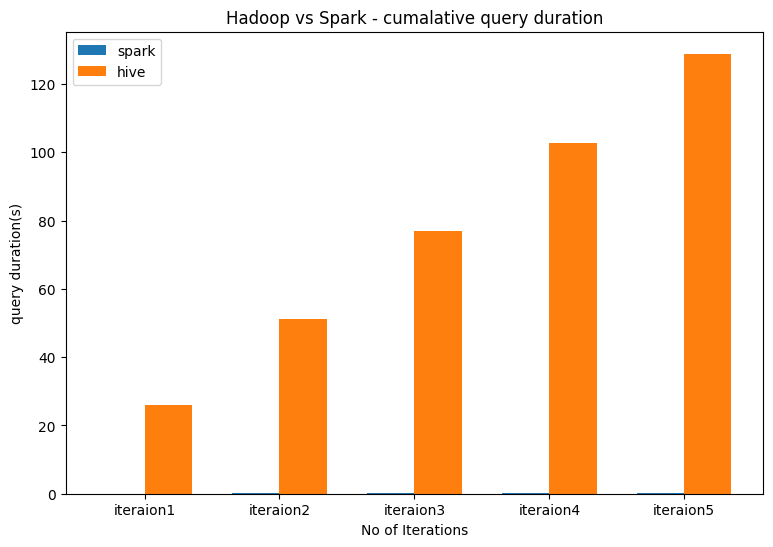

In [62]:
x = range(len(hive_cum_exec_times))
bar_width=0.35

fig, ax = plt.subplots(figsize=(9,6))
bars1 = ax.bar(x, spark_cum_exec_times, width=bar_width, label='spark')
bars2 = ax.bar([i + bar_width for i in x], hive_cum_exec_times, width=bar_width, label='hive')
ax.set_xlabel('No of Iterations')
ax.set_ylabel('query duration(s)')
ax.set_title('Hadoop vs Spark - cumalative query duration')
ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(['iteraion'+str(i+1) for i in range(5)])
ax.legend()
plt.show()

In [71]:
df = pd.DataFrame({
    'query': queries,
    'Spark-SQL': spark_avg_qdurations,
    'HiveQL': hive_avg_qdurations
    })
df

,query,Spark-SQL,HiveQL
0,Avg Carrier Delay,0.061040,25.92
1,Avg Weather Delay,0.022768,25.35
2,Avg NAS Delay,0.020530,25.60
3,Avg Security Delay,0.019676,25.81
4,Avg LateAircraft Delay,0.017797,26.20


In [91]:
from matplotlib.ticker import FuncFormatter

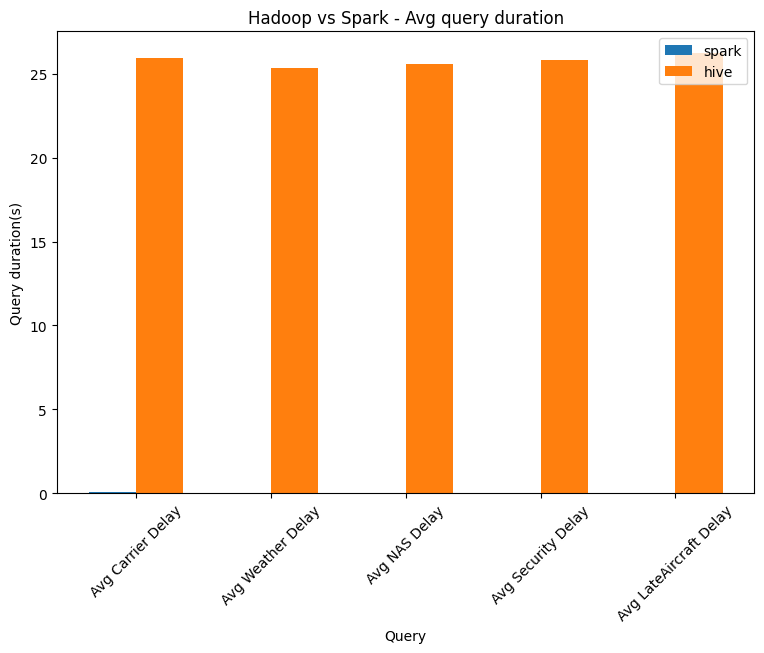

In [97]:
x = range(len(hive_cum_exec_times))
bar_width=0.35

fig, ax = plt.subplots(figsize=(9,6))
bars1 = ax.bar(x, spark_avg_qdurations, width=bar_width, label='spark')
bars2 = ax.bar([i + bar_width for i in x], hive_avg_qdurations, width=bar_width, label='hive')
ax.set_xlabel('Query')
ax.set_ylabel('Query duration(s)')
ax.set_title('Hadoop vs Spark - Avg query duration')
ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(queries,rotation=45)

ax.legend()
plt.show()